In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ab5vlh7h
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ab5vlh7h


# Entrenamiento Modelo completo

In [2]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt

Se debe cambiar el directorio donde se tenga la carpeta de entrenamiento

In [4]:
dataset_directory ="train/"
df1 = pd.read_csv(dataset_directory+"data.csv")
df1 = shuffle(df1).reset_index(drop=True)
df1 = shuffle(df1).reset_index(drop=True)
df1 = df1[df1['image_lvl_label'].notna()].reset_index(drop=True)
len(df1)
df1.head(2)

,timestamp,kiwibot_id,gps_point,lon,lat,roll,pitch,yaw,linear_speed,angular_speed,image_path,depth_path,image_lvl_label,label_path
0,2022-01-18 03:38:00.035000+00:00,4A009,POINT(-118.43214 33.955748),-118.432140,33.955748,0.042542,-0.137445,-0.586867,1.023086,-0.033535,ba81-camera_color_image_raw-1642477080035.jpg,ba81-camera_aligned_depth_to_color_image_raw-1...,2.0,ba81-camera_color_image_raw-1642477080035_seg.png
1,2022-01-20 01:59:56.194000+00:00,4A009,POINT(-118.418205 33.968853),-118.418205,33.968853,0.001091,0.001091,0.001091,0.926350,0.000000,18e9-camera_color_image_raw-1642643996194.jpg,18e9-camera_aligned_depth_to_color_image_raw-1...,2.0,18e9-camera_color_image_raw-1642643996194_seg.png


## Creación Dataset con las 3 columnas, 1 entrada y 2 labels

In [5]:
filenames  =list(df1['image_path'].map(lambda  x:dataset_directory+x))
labels= list(df1['label_path'].map(lambda  x:dataset_directory+x))
label_clasi = list(df1['image_lvl_label'])


train_filenames = filenames[:1500]
test_filenames = filenames[:-100]

train_labels = labels[:1500]
test_labels  = labels[:-100]

train_labels_clasi = label_clasi[:1500]
test_labels_clasi  = label_clasi[:-100]



In [6]:
dataset_train =tf.data.Dataset.from_tensor_slices((train_filenames, train_labels, train_labels_clasi))
dataset_test  =tf.data.Dataset.from_tensor_slices((test_filenames, test_labels,test_labels_clasi ))

In [7]:
def _parse_function(filename, label, label_2):
    image_string = tf.io.read_file (filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)

    label_string = tf.io.read_file(label)
    label = tf.image.decode_png(label_string, channels=1)
    return image, label, label_2

dataset_train = dataset_train.map(_parse_function)
dataset_test = dataset_test.map(_parse_function)

In [8]:
dataset_train

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [9]:
IMG_HEIGHT  =180 #720
IMG_WIDTH = 320#1280
CHANNELS = 3

In [10]:
def normalize(input_image, input_mask, clasification_label):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
  
  input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH))

  return input_image, {'img':input_mask, 'classification':clasification_label}

In [11]:
TRAIN_LENGTH = 1500
BATCH_SIZE = 64
BUFFER_SIZE = 2000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train_images = dataset_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_images  =  dataset_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels['img'] = self.augment_labels(labels['img'])
    return inputs, labels

In [14]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [15]:
def display(display_list, classification):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i]+ "  classification "+str(classification[i]))
    img=tf.keras.utils.array_to_img(display_list[i])
    plt.imshow(img)
    plt.axis('off')
  plt.show()

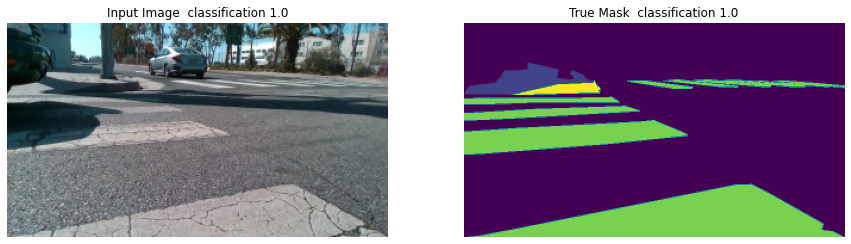

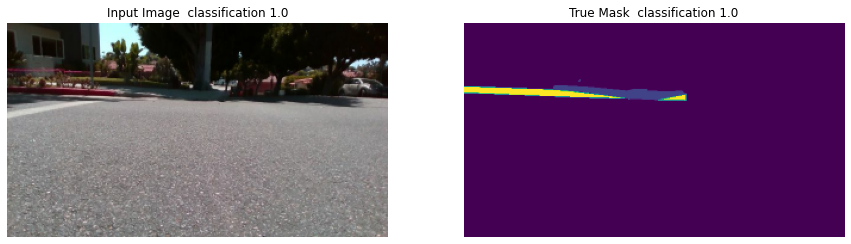

In [16]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks['img'][0]
  display([sample_image, sample_mask], [masks['classification'][0].numpy(),masks['classification'][0].numpy()])

## Creación Modelo completo

Se llama el modelo de segmentación semantica con mejores resultados para aprovechar la aproximación que se habia hecho

In [49]:
model_save = tf.keras.models.load_model('saved_model\my_model_mean_iou_94')
model_save.trainable = True

Se crea una función para crear la definición del modelo

In [80]:

def modelo_def():

    input_shape = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    img_resize = tf.keras.layers.Resizing(
    128,
    128,
    interpolation='bilinear',
    )(input_shape)

    # 180*320
    after_pretrained= model_save(img_resize)# 128x128 

    conv_6 =  tf.keras.layers.Conv2D(filters=6, 
                    kernel_size=(3,3), 
                    activation='relu',
                    padding='same')(after_pretrained)

    
    conv_5 =  tf.keras.layers.Conv2D(filters=10, 
                    kernel_size=(3,3), 
                    activation='relu',
                    padding='same')(img_resize)
    
        
    conv_5 =  tf.keras.layers.Conv2D(filters=10, 
                    kernel_size=(3,3), 
                    activation='relu',
                    padding='same')(conv_5)

    #conv_6 = tf.keras.layers.concatenate([conv_5, conv_6], axis=3, name = 'oto')


    conv_7 =  tf.keras.layers.Conv2D(filters=12, 
                        kernel_size=(3,3),
                        activation='relu',
                        padding='valid')(conv_5)

    max_7 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(conv_7)
    
    conv_7 =  tf.keras.layers.Conv2D(filters=18, 
                        kernel_size=(3,3),
                        activation='relu',
                        padding='valid')(max_7)
    conv_7 =  tf.keras.layers.Conv2D(filters=24, 
                        kernel_size=(3,3),
                        activation='relu',
                        padding='valid')(conv_7)

    max_7 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(conv_7)

    conv_7 =  tf.keras.layers.Conv2D(filters=18, 
                        kernel_size=(3,3),
                        activation='relu',
                        padding='valid')(conv_7)
    conv_7 =  tf.keras.layers.Conv2D(filters=12, 
                        kernel_size=(3,2),
                        activation='relu',
                        padding='valid')(conv_7)

    max_7 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    strides=(1,1),
    padding='valid')(conv_7) 

    conv_7 =  tf.keras.layers.Conv2D(filters=12, 
                        kernel_size=(3,1),
                        activation='relu',
                        padding='valid')(conv_7)
    conv_7 =  tf.keras.layers.Conv2D(filters=12, 
                        kernel_size=(3,1),
                        activation='relu',
                        padding='valid')(conv_7)


    max_7 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    strides=(1,1),
    padding='valid')(conv_7)   ## 90*107 


    
    max_8 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2,2),
    padding='same')(max_7)   ## 90*107 

    conv_9 =  tf.keras.layers.Conv2D(filters=5, 
                        kernel_size=(3,3),
                        activation='relu',
                        padding='same')(max_8)
    max_9 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2,2),
    padding='same')(conv_9)   ## 90*107


    flat = tf.keras.layers.Flatten(input_shape=(12, 14, 5))(max_9)
    dense = tf.keras.layers.Dense(200, activation='relu')(flat)
    dense = tf.keras.layers.Dense(200, activation='relu')(dense)
    dense =tf.keras.layers.Dense(3, activation='softmax',name = 'classification')(dense) 


    tam_original= tf.keras.layers.Resizing(
    IMG_HEIGHT, IMG_WIDTH,
    interpolation='bilinear', name = 'img'
    )(after_pretrained)

    after_pretrained


    model = tf.keras.Model(input_shape, [tam_original,dense])
    return model


In [ ]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def _init_(self, num_classes):

        super()._init_(num_classes= num_classes)

        self.num_classes = num_classes
    def update_state(self, y_true, y_pred, sample_weight=None):
        
        pred_mask = tf.argmax(y_pred, axis=-1)

        return super().update_state(y_true,pred_mask)

Este apartado se usa para entrenar nuevamente todo el modelo, incluyendo el de segmentación, en este caso se entrenara el modelo completamente

In [ ]:
model = modelo_def()
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss={'img':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),'classification':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics={'img':[MeanIoU(6)],'classification':'accuracy'})

Para entrenar solo la clasificación descomentar el codigo, no se usa este función

In [96]:
#model = modelo_def()
#model.summary()
#opt = tf.keras.optimizers.Adam(learning_rate=0.0000002)
#model.compile(optimizer=opt,
              #loss={'classification':tf.keras.losses.SparseCategoricalCrossentropy()},
              #metrics={'classification':'accuracy'})

In [52]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def create_clasification(resul_class):
  resul = tf.argmax(resul_class,axis=-1)
  return resul[0].numpy()

In [53]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask, resul_clasification = model.predict(image)
      display([image[0], mask['img'][0], create_mask(pred_mask)],[mask['classification'][0].numpy(),mask['classification'][0].numpy(),create_clasification(resul_clasification)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [54]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(test_batches, 1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Entrenar Modelo Completo

2/2 [==============================] - 3s 1s/step


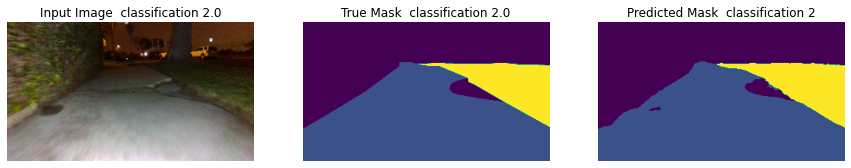


Sample Prediction after epoch 1

23/23 [==============================] - 64s 3s/step - loss: 0.9265 - classification_loss: 0.9265 - classification_accuracy: 0.5856


In [98]:
EPOCHS = 1
VAL_SUBSPLITS = 6
VALIDATION_STEPS = 100//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

2/2 [==============================] - 3s 1s/step


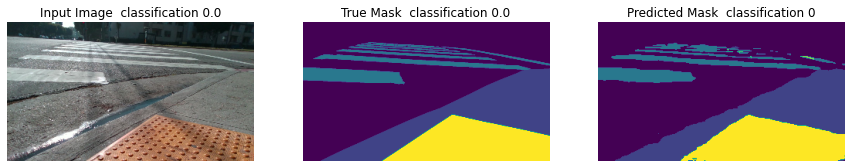

In [67]:
show_predictions(train_batches, 1)
#model.save('saved_model/my_model_mio_94_acc_90')

## Prueba de modelos entrenados


Se llama el modelo con mejores resultados para probar su efectividad 

In [75]:
new_model = tf.keras.models.load_model('saved_model\my_model_mio_94_acc_90')

2/2 [==============================] - 4s 1s/step


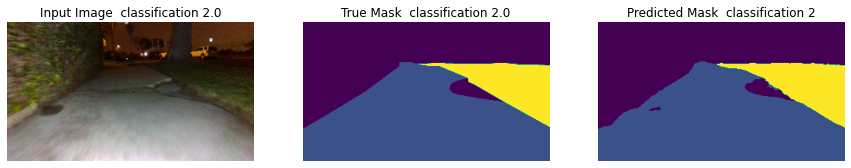

2/2 [==============================] - 3s 1s/step


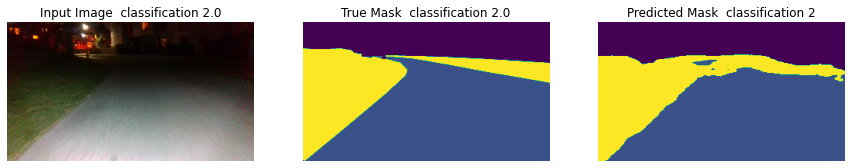

2/2 [==============================] - 3s 1s/step


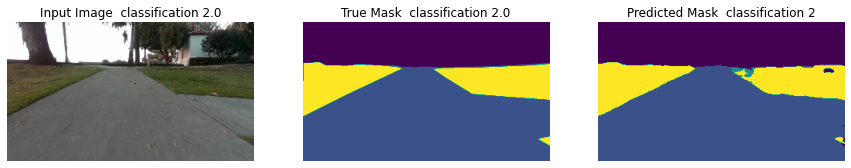

2/2 [==============================] - 3s 1s/step


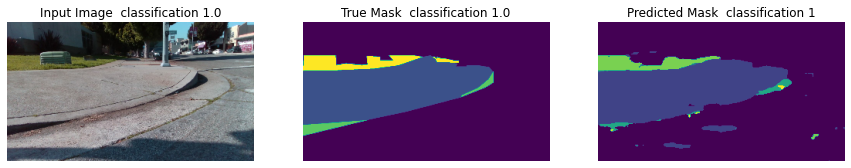

2/2 [==============================] - 4s 2s/step


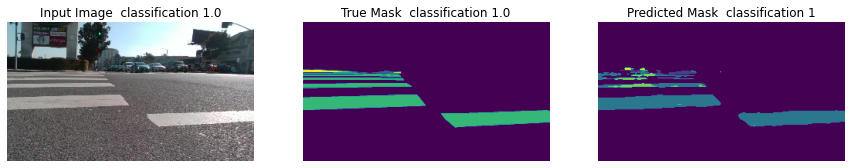

2/2 [==============================] - 3s 1s/step


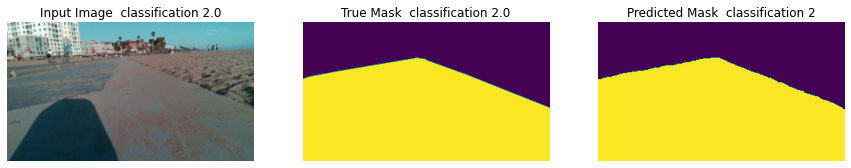

In [77]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask, resul_clasification = new_model.predict(image)
      display([image[0], mask['img'][0], create_mask(pred_mask)],[mask['classification'][0].numpy(),mask['classification'][0].numpy(),create_clasification(resul_clasification)])
  else:
    display([sample_image, sample_mask,
             create_mask(new_model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(test_batches,6)